In [1]:
from lightgbm import LGBMRegressor

import gc
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from Interaction_effect_features import get_data

import warnings
warnings.filterwarnings('ignore')
np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def last_preprocessing(data_dict,feature_columns,dependent_variable,dataset):
    
    if dataset == 'regression':
        columns = ['AdjustedLeadTime_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_percentEncoded', 'CumulativeNumberOfRooms_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countEncoded', 'CumulativeRevenue_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countRankEncoded', 'CumulativeRevenue_Quartile_MeanEncoded', 'CumulativeRevenueSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countRankEncoded', 'CumulativeRevenueNet_Quartile_percentEncoded', 'CumulativeRevenueNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_MeanEncoded','AdjustedLeadTime_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_percentEncoded','AdjustedLeadTime_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countEncoded', 'CumulativeRevenueSubstract_Quartile_MeanEncoded', 'CumulativeRevenueNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countEncoded','AdjustedLeadTime_Quartile_MeanEncoded', 'CumulativeNumberOfRooms_Quartile_countEncoded', 'CumulativeRevenueNet_Quartile_countRankEncoded','AdjustedLeadTimeCumulativeRevenue_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_percentEncoded']
    else:
        columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']
    
    for feature in columns:
        if feature in feature_columns and feature in data_dict['data_external_test'].columns:
            data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
            data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)

            for index in data_dict['fold_dict'].keys():
                data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
                data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)
    
#     print('ReservedRoomType_countEncoded' in data_dict['fold_dict'][3]['fold_training'])
#     print('ReservedRoomType_countEncoded' in data_dict['fold_dict'][3]['fold_test'])
#     print('ReservedRoomType_countEncoded' in data_dict['data_validation_test'])
#     print('ReservedRoomType_countEncoded' in data_dict['data_external_test'])
    
    fold_training = data_dict['fold_dict'][1]['fold_training'][feature_columns+dependent_variable]
    fold_test = data_dict['fold_dict'][1]['fold_test'][feature_columns+dependent_variable]
    data_validation_test = data_dict['data_validation_test'][feature_columns+dependent_variable]
    data_external_test = data_dict['data_external_test'][feature_columns+dependent_variable]
    
    #append
    training_df = fold_training.append([fold_test, data_validation_test], ignore_index=True)
    training_df.reset_index(inplace=True,drop=True)
    
    return training_df,data_external_test

In [4]:
#features_regression = 
with open(r"D:\Results\ResultPickle\PredictRoomBooking\best_columns_GA_PredictRoomBooking_lightgbm_v4.pickle", "rb") as features_regression:
    features_regression = pickle.load(features_regression)

#'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
problem = 'PredictRoomBooking'
data_dict_regression,dependent_variable_regression,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = get_data(problem)

#create single dataframe
training_df_regression,data_external_test_regression = last_preprocessing(data_dict=data_dict_regression,
                                                    feature_columns=features_regression,
                                                    dependent_variable=dependent_variable_regression,
                                                    dataset='regression')

# Train Models

In [5]:
regression_model = LGBMRegressor(n_estimators=200,random_state=1,n_jobs=-1)
regression_model.fit(training_df_regression[features_regression],training_df_regression[dependent_variable_regression])

LGBMRegressor(n_estimators=200, random_state=1)

In [46]:
features_regression

['AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_Encoded',
 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_Encoded',
 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_Encoded',
 'CumulativeNumberOfRoomsNet_Quartile_Encoded',
 'CumulativeNumberOfRoomsSubstract_Quartile_Encoded',
 'CumulativeRevenueSubstract_Quartile_Encoded',
 'DayOfMonth_Encoded',
 'DayOfWeek_Encoded',
 'MonthOfYear_Encoded']

## Individual Conditional Expectation Plots

In [6]:
from sklearn.inspection import PartialDependenceDisplay

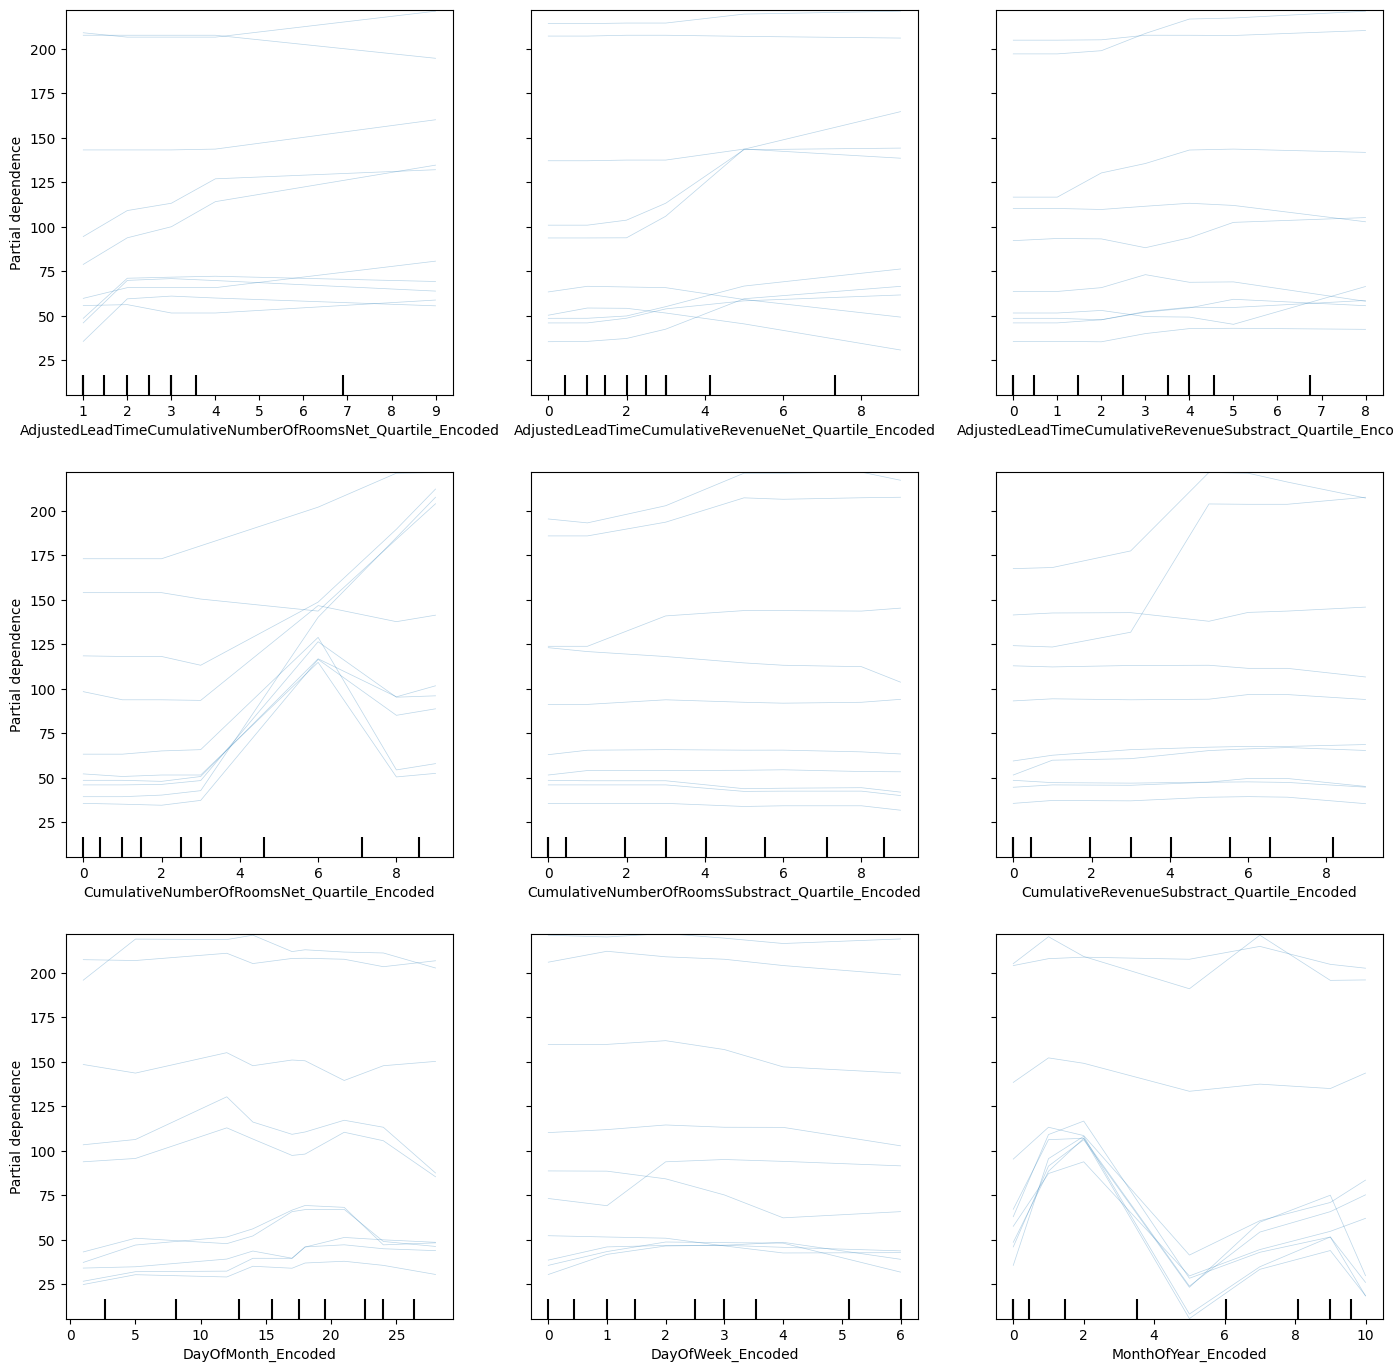

In [45]:
row_1 = 3
row_2 = 400
plt.rcParams["figure.figsize"] = (17,17)
PartialDependenceDisplay.from_estimator(estimator=regression_model,
                                        X = training_df_regression[features_regression].head(10),
                                        features = features_regression,
                                        feature_names = features_regression,
                                        kind='individual')
plt.show()

In [39]:
training_df_regression[features_regression].iloc[row_number_in_test_data]

AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_Encoded     4
AdjustedLeadTimeCumulativeRevenueNet_Quartile_Encoded           5
AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_Encoded     5
CumulativeNumberOfRoomsNet_Quartile_Encoded                     6
CumulativeNumberOfRoomsSubstract_Quartile_Encoded               8
CumulativeRevenueSubstract_Quartile_Encoded                     7
DayOfMonth_Encoded                                              5
DayOfWeek_Encoded                                               6
MonthOfYear_Encoded                                            10
Name: 3, dtype: int64

## Local interpretable model-agnostic explanations

In [11]:
import lime.lime_tabular

In [54]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_df_regression[features_regression].values,
                                                   feature_names=features_regression,
                                                   class_names=dependent_variable_regression,
                                                   mode='regression')

# explainer.explain_instance(test[i], rf.predict, num_features=5)

row_number_in_test_data = 3
exp = explainer.explain_instance(data_external_test_regression[features_regression].iloc[row_number_in_test_data],
                                 regression_model.predict,
                                 num_features=len(features_regression))#,
#                                  top_labels=1)

exp.show_in_notebook(show_table=True)



In [52]:
data_external_test_regression[features_regression].iloc[[row_number_in_test_data], :]

,AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_Encoded,AdjustedLeadTimeCumulativeRevenueNet_Quartile_Encoded,AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_Encoded,CumulativeNumberOfRoomsNet_Quartile_Encoded,CumulativeNumberOfRoomsSubstract_Quartile_Encoded,CumulativeRevenueSubstract_Quartile_Encoded,DayOfMonth_Encoded,DayOfWeek_Encoded,MonthOfYear_Encoded
3,5,5,4,6,5,5,20,1,1


## Counterfactual Model Explanations

In [21]:
from alibi.explainers import ALE, plot_ale

In [22]:
lightgbm_ale = ALE(regression_model.predict,
             feature_names=features_regression,
             target_names=dependent_variable_regression)

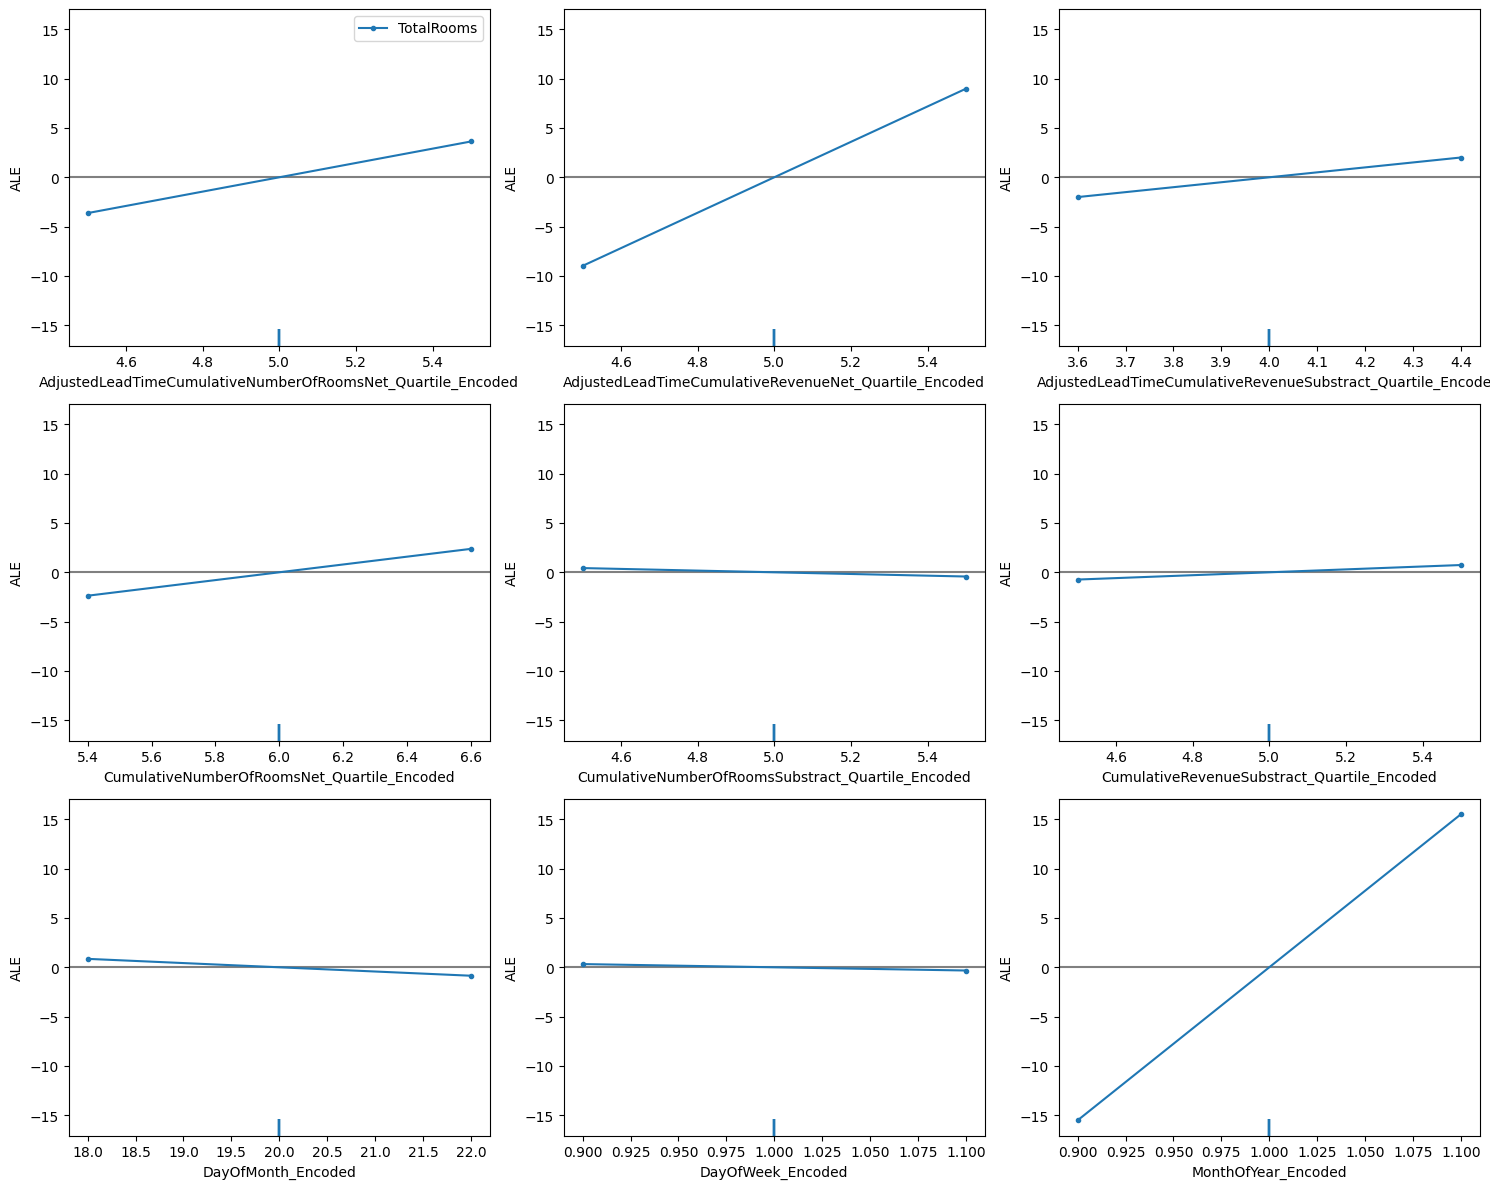

In [31]:
row_number_in_test_data = 3
lightgbm_exp = lightgbm_ale.explain(data_external_test_regression[features_regression].iloc[[row_number_in_test_data], :].values)
plt.rcParams["figure.figsize"] = (15,12)
plot_ale(lightgbm_exp)
plt.show()

## SHAP

In [55]:
import shap

In [56]:
row_number_in_test_data = 3

In [57]:
shap_values = shap.TreeExplainer(regression_model).shap_values(
    data_external_test_regression[features_regression].iloc[[row_number_in_test_data], :])

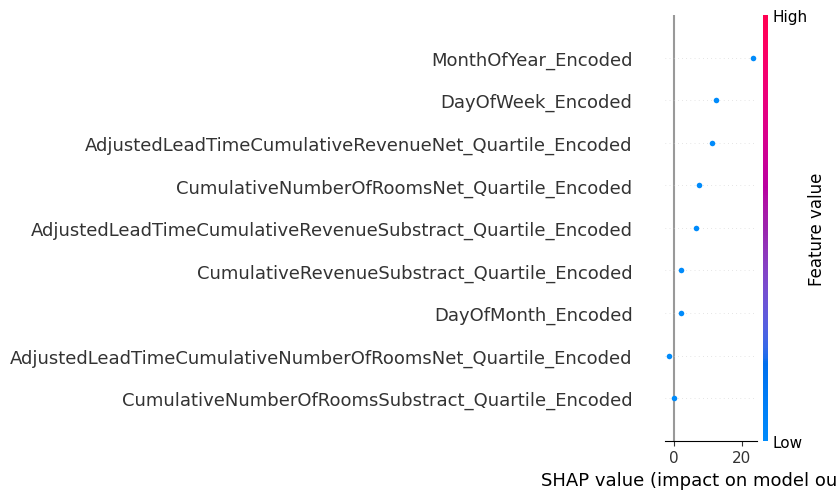

In [58]:
shap.summary_plot(shap_values,
                  data_external_test_regression[features_regression].iloc[[row_number_in_test_data], :],
                  max_display=len(features_regression))